# Active Learning

## 1.0 Imports

In [2]:
#import libraries

#Data extraction and manipulation
import pandas as pd 
import pymysql as pml
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

#Machine Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Evaluation Metrics
from sklearn.metrics import roc_auc_score, average_precision_score

#Data Visualization
from sklearn.tree import plot_tree
import matplotlib.pylab as plt

## 2.0 Data Extraction

In [3]:
def connect_to_db(host_name, username, password, dbname, port):
    try:  
        conn = pml.connect(host= host_name, user = username, password = password, port = port,database = dbname )
    
    except pml.OperationalError as e:
        raise e
    else:
        print('Connected!')
    return conn 

In [4]:
def extract_data(curr):
    curr.execute("SELECT * FROM animes WHERE media_type = 'tv' or media_type = 'ova' ")
    df = pd.DataFrame(curr.fetchall())
    return df

In [33]:
#database credentials
host_name = 'personalproject.crpcbnfr4nbk.us-east-1.rds.amazonaws.com'
username = 'admin'
password = 'ad5c7455'
dbname = 'personal_projects'
port = 3306
conn = None

#establish a connection to db
conn = connect_to_db(host_name, username, password, dbname, port)
curr = conn.cursor()

df = extract_data(curr)

Connected!


In [34]:
#Rename the columns
df.columns = ['anime_id','title' ,'genre' ,'mean_score', 'media_type', 'num_episodes',
                'picture', 'rating', 'status', 'start_date','end_date']

## 3.0 Labeling

In this poroject the labels will be made by hand. I'm going to use google sheets to create a new column called 'y' and classifier wether i like (1) or not (0) each anime based on name, number of episodes and the mean_score. For starters i'm going to make labels for about 600 animes.

In [35]:
#Export the data for labeling 
df.to_csv('animes_to_label.csv')

In [36]:
#Read the data with labels and load into a dataframe 
df_animes_with_labels = pd.read_csv('animes_with_label.csv', index_col=0)
#keep only those with label
df_animes_with_labels = df_animes_with_labels[df_animes_with_labels['y'].notnull()] 
df_animes_with_labels.shape

(605, 11)

In [37]:
df_animes_with_labels.head(3)

,title,genre,mean_score,media_type,num_episodes,picture,rating,status,start_date,end_date,y
anime_id,,,,,,,,,,,
1,Cowboy Bebop,Action,8.76,tv,26,https://api-cdn.myanimelist.net/images/anime/4...,r,finished_airing,1998-04-03,1999-04-24,1.0
6,Trigun,Action,8.22,tv,26,https://api-cdn.myanimelist.net/images/anime/7...,pg_13,finished_airing,1998-04-01,1998-09-30,1.0
7,Witch Hunter Robin,Action,7.26,tv,26,https://api-cdn.myanimelist.net/images/anime/1...,pg_13,finished_airing,2002-07-02,2002-12-24,0.0


## 4.0 Understanding The Features

In [38]:
def data_split(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        random_state=42)
    return X_train, X_test, y_train, y_test

def X_split(X, test_size):
    X_train, X_test = train_test_split(X, test_size=test_size,
                                                        random_state=42)
    return X_train, X_test

In [39]:
#Split the data with labels
X = df_animes_with_labels[['mean_score', 'num_episodes']]
y = df_animes_with_labels['y'].copy()

X_train, X_test, y_train, y_test = data_split(X, y, 0.5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((302, 2), (303, 2), (302,), (303,))

In [40]:
#Training a Decision Tree
mdl = DecisionTreeClassifier(random_state= 0, max_depth=2, class_weight="balanced")
mdl.fit(X_train, y_train)

probability_score = mdl.predict_proba(X_test)[:,1]

In [41]:
average_precision_score(y_test, probability_score), roc_auc_score(y_test, probability_score)

(0.31320971080158866, 0.6524381772714642)

[Text(0.5, 0.8333333333333334, 'mean_score <= 7.79\ngini = 0.5\nsamples = 302\nvalue = [151.0, 151.0]'),
 Text(0.25, 0.5, 'num_episodes <= 121.5\ngini = 0.441\nsamples = 195\nvalue = [110.647, 53.929]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.428\nsamples = 192\nvalue = [109.996, 49.614]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.228\nsamples = 3\nvalue = [0.651, 4.314]'),
 Text(0.75, 0.5, 'mean_score <= 8.17\ngini = 0.415\nsamples = 107\nvalue = [40.353, 97.071]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.472\nsamples = 67\nvalue = [29.289, 47.457]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.298\nsamples = 40\nvalue = [11.065, 49.614]')]

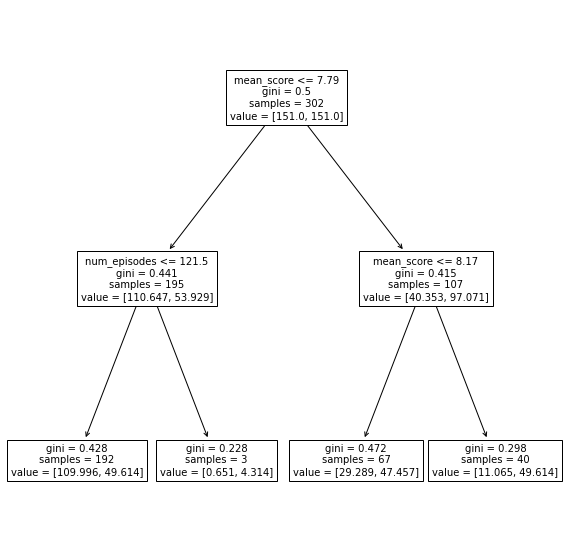

In [42]:
#Resize the figure
plt.figure(figsize = (10,10))
#Pot the tree
plot_tree(mdl, feature_names= X_train.columns)

- Animes those has a mean_score lower or equal to 7.79 and  121.5 episodes or less, are more interesting for me.

The baseline for Average Precision and AUC Score:
(0.31320971080158866, 0.6524381772714642)

The active learning goal is surpass this values.

### 4.1 Featuring the titles

In [43]:
def word_vectorizer(word_train, word_test, min_df):
    word_vec = TfidfVectorizer(min_df= min_df)
    word_bow_train = word_vec.fit_transform(word_train)
    word_bow_test = word_vec.transform(word_test)
    
    return word_bow_train, word_bow_test

In [44]:
#Split the titles in training and test
title_train, title_test = X_split(df_animes_with_labels['title'], 0.5)

In [45]:
#Vectorizer the titles with min_df =1 and min_df = 2 to test the results
title_bow_train, title_bow_test = word_vectorizer(title_train, title_test, 1)
title_bow_train_md2, title_bow_test_md2 = word_vectorizer(title_train, title_test, 2)

In [46]:
title_bow_train.shape, title_bow_train_md2.shape

((302, 727), (302, 170))

In [94]:
#Merge the train and test data from title, mean_score and num_episodes
Xtrain = hstack([X_train, title_bow_train])
Xtest = hstack([X_test, title_bow_test])
Xtrain_md2 = hstack([X_train, title_bow_train_md2])
Xtest_md2 = hstack([X_test, title_bow_test_md2])

In [48]:
Xtrain.shape, Xtrain_md2.shape

((302, 729), (302, 172))

In [49]:
mdl = RandomForestClassifier(n_estimators = 1000, random_state= 0, class_weight="balanced")

mdl.fit(Xtrain_md2, y_train)
probability_score_md2 = mdl.predict_proba(Xtest_md2)[:,1]

mdl.fit(Xtrain, y_train)
probability_score_md1 = mdl.predict_proba(Xtest)[:,1]

In [50]:
average_precision_score(y_test, probability_score_md1), roc_auc_score(y_test, probability_score_md1)

(0.5458583250045408, 0.782126979716588)

In [51]:
average_precision_score(y_test, probability_score_md2),roc_auc_score(y_test, probability_score_md2)

(0.35773861137119, 0.6698041122534039)

With the titles and a more complex model the baseline was suprassed. The min_df = 1 was much better than 2. 


Baseline: (0.31320971080158866, 0.6524381772714642)

---
Randomforest, tfvectorizer, min_df = 2: (0.35773861137119, 0.6698041122534039)

---
Randomforest, tfvectorizer, min_df = 1: (0.5458583250045408, 0.782126979716588)

## 5.0 Labeling New Data

Now i'm going to label the data which the model had trouble to predict if is or not interesting.

In [52]:
#Read the data with labels and load into a dataframe 
df_unlabeled = pd.read_csv('animes_with_label.csv', index_col=0)
df_unlabeled = df_unlabeled[df_unlabeled['y'].isnull()].dropna(how= 'all')
df_unlabeled.shape

(1202, 11)

In [53]:
df_unlabeled.head(1)

,title,genre,mean_score,media_type,num_episodes,picture,rating,status,start_date,end_date,y
anime_id,,,,,,,,,,,
483,Kurau Phantom Memory,Action,7.32,tv,24,https://api-cdn.myanimelist.net/images/anime/1...,pg_13,finished_airing,2004-06-25,2004-12-16,NaN


In [54]:
#Vectorizing the titles for the unlabeled data
title_bow_unlabeled = word_vectorizer(title_train, df_unlabeled['title'], 1)[1]

#Creating the features with the merge of title vectorized, num_episodes and mean_score
X_unlabeled = hstack([df_unlabeled[['mean_score', 'num_episodes']], title_bow_unlabeled])

In [55]:
#Creating a new columns in the dataframe with the probability score for each anime
probability_score_unlabeled = mdl.predict_proba(X_unlabeled)[:, 1]
df_unlabeled['p'] = probability_score_unlabeled

In [56]:
df_unlabeled.head()

,title,genre,mean_score,media_type,num_episodes,picture,rating,status,start_date,end_date,y,p
anime_id,,,,,,,,,,,,
483,Kurau Phantom Memory,Action,7.32,tv,24,https://api-cdn.myanimelist.net/images/anime/1...,pg_13,finished_airing,2004-06-25,2004-12-16,NaN,0.003
485,Damekko Doubutsu,Anthropomorphic,7.26,tv,26,https://api-cdn.myanimelist.net/images/anime/1...,g,finished_airing,2005-01-17,2005-02-21,NaN,0.007
486,Kino no Tabi: The Beautiful World,Action,8.30,tv,13,https://api-cdn.myanimelist.net/images/anime/1...,r,finished_airing,2003-04-08,2003-07-08,NaN,0.277
488,Ichigo Mashimaro,CGDCT,7.64,tv,12,https://api-cdn.myanimelist.net/images/anime/1...,pg_13,finished_airing,2005-07-15,2005-10-14,NaN,0.069
489,Kamichu!,Comedy,7.38,tv,12,https://api-cdn.myanimelist.net/images/anime/3...,g,finished_airing,2005-06-29,2005-09-27,NaN,0.028


In [68]:
#Filtering about 160 samples from the dataset which the probability score is close to 0.5
mask_unlabeled = (df_unlabeled['p'] >= 0.32) & (df_unlabeled['p'] <= 0.65)
mask_unlabeled.sum()

152

In [69]:
#Creating a new df with this filtered data 
df_filtered = df_unlabeled[mask_unlabeled]
df_filtered.head(2)

,title,genre,mean_score,media_type,num_episodes,picture,rating,status,start_date,end_date,y,p
anime_id,,,,,,,,,,,,
516,Keroro Gunsou,Comedy,7.69,tv,358,https://api-cdn.myanimelist.net/images/anime/2...,pg_13,finished_airing,2004-04-03,2011-04-04,NaN,0.415
527,Pokemon,Action,7.36,tv,276,https://api-cdn.myanimelist.net/images/anime/1...,pg,finished_airing,1997-04-01,2002-11-14,NaN,0.326


In [72]:
#Creating a second dataframe with 46 new random samples
df_random = df_unlabeled[~mask_unlabeled].sample(48)

In [73]:
#Merge the 2 dataframes above and export for labeling
df_merged = pd.concat([df_filtered, df_random])
df_merged.to_csv("active_label3.csv")

## 6.0 Adding New Data to The Model

In [74]:
#Creating a new dataframe with the new labeled data 
df_active_learning = pd.read_csv("active_label_done.csv", index_col= 0)
df_active_learning = df_active_learning[df_active_learning['y'].notnull()]
df_active_learning.shape

(200, 12)

In [75]:
#Check the score for the predictions
print(average_precision_score(df_active_learning['y'], df_active_learning['p']),
roc_auc_score(df_active_learning['y'], df_active_learning['p']))

0.6320046325995216 0.6760374832663989


### 6.1 Adding New Data to Test Set

In [81]:
#Concat the new data to test set
X_test_plus = pd.concat([X_test, df_active_learning[['mean_score', 'num_episodes']]])
y_test_plus = pd.concat([y_test, df_active_learning['y']])
title_test_plus = pd.concat([title_test, df_active_learning['title']])

In [82]:
#Vectorizig the new title bag of words
title_bow_train, title_bow_test_plus = word_vectorizer(title_train, title_test_plus, 1)

In [83]:
#Concat the title with the other features
Xtest_plus = hstack([X_test_plus, title_bow_test_plus])

In [84]:
#Predict the score for new test set
mdl.fit(Xtrain, y_train)
probability_score_test_plus = mdl.predict_proba(Xtest_plus)[:,1]

In [85]:
print(average_precision_score(y_test_plus, probability_score_test_plus), 
      roc_auc_score(y_test_plus, probability_score_test_plus))

0.6149893004819301 0.7838457336818696


### 6.2 Adding New Data to Training Set

In [95]:
#Concat the new data to training set
X_train_plus = pd.concat([X_train, df_active_learning[['mean_score', 'num_episodes']]])
y_train_plus = pd.concat([y_train, df_active_learning['y']])
title_train_plus = pd.concat([title_train, df_active_learning['title']])

In [96]:
#Vectorizig the new title bag of words
title_bow_train_plus, title_bow_test = word_vectorizer(title_train_plus, title_test, 1)

In [97]:
#Concat the title with the other features
Xtrain_plus = hstack([X_train_plus, title_bow_train_plus])

In [98]:
#Fit model with new training set
mdl.fit(Xtrain_plus, y_train_plus)
probability_score_train_plus = mdl.predict_proba(Xtest)[:, 1]

In [99]:
print(average_precision_score(y_test, probability_score_train_plus), 
      roc_auc_score(y_test, probability_score_train_plus))

0.5621024588519278 0.7926160044456794


### 6.3 Adding New Data to All Set

In [222]:
#Concat the datasets
df_merged = pd.concat([df_animes_with_labels, df_active_learning])
df_merged = df_merged.reset_index()
#Split the data with labels
X = df_merged[['mean_score', 'num_episodes']]
y = df_merged['y'].copy()

X_train, X_test, y_train, y_test = data_split(X, y, 0.5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((402, 2), (403, 2), (402,), (403,))

In [202]:
#Split the titles in training and test
title_train, title_test = X_split(df_merged['title'], 0.5)

In [203]:
#Vectorizer the titles 
title_bow_train, title_bow_test = word_vectorizer(title_train, title_test, 1)

In [204]:
#Merge the train and test data from title, mean_score and num_episodes
Xtrain = hstack([X_train, title_bow_train])
Xtest = hstack([X_test, title_bow_test])

In [205]:
mdl.fit(Xtrain, y_train)
probability_score_all = mdl.predict_proba(Xtest)[:,1]

In [206]:
average_precision_score(y_test, probability_score_all), roc_auc_score(y_test, probability_score_all)

(0.5938156353740196, 0.7491790856276839)

## 7.0 Active Learning Performance

#### Baseline

(0.1905110498657493, 0.6720502770644681)

---
#### RandomForest + TfidfVectorizer

(0.5458583250045408, 0.782126979716588)

---
#### Active learnig on all data set + RandomForest + TfidfVectorizer

(0.6149893004819301, 0.7838457336818696)
 
**With this results, this dataset is ready for modeling**


## 8.0 Save The Dataset

In [106]:
def create_table(curr):
    create_table_command = (""" CREATE TABLE IF NOT EXISTS animes_labeled (
                            anime_id INT(255) PRIMARY KEY,
                            title VARCHAR(120) NOT NULL,
                            genre VARCHAR(120),
                            mean_score FLOAT(3,2),
                            media_type VARCHAR(15) NOT NULL,
                            num_episodes INT(6),
                            picture VARCHAR(200) NOT NULL,
                            rating VARCHAR(15) NOT NULL,
                            status VARCHAR(60) NOT NULL,
                            start_date DATE NOT NULL,
                            end_date DATE,
                            y VARCHAR(2) NOT NULL
                        )""")
    
    curr.execute(create_table_command)
    return None

In [109]:
def inster_into_table(curr, anime_id, title, genre, mean_score, media_type,
    num_episodes, picture, rating, status, start_date, end_date, y):

    insert = (""" INSERT INTO animes_labeled( anime_id,
                title,             
                genre,
                mean_score,
                media_type,
                num_episodes,
                picture,
                rating,
                status,
                start_date,
                end_date,
                y)
                VALUES(%s, %s, %s, %s ,%s ,%s ,%s ,%s ,%s ,%s, %s, %s)
                """)
    row_to_insert = (anime_id, title, genre, mean_score, media_type,
    num_episodes, picture, rating, status, start_date, end_date, y)
    
    curr.execute(insert, row_to_insert)
    
    return None

In [107]:
def apprend_from_df_to_db(curr, df):
    for i, row in df.iterrows():
        inster_into_table(curr,row['anime_id'],  row['title'], row['genre'], row['mean_score'], row['media_type'], 
                       row['num_episodes'], row['picture'], row['rating'], row['status'], 
                       row['start_date'], row['end_date'], row['y'])
    return None

In [220]:
#database credentials
host_name = 'personalproject.crpcbnfr4nbk.us-east-1.rds.amazonaws.com'
username = 'admin'
password = 'ad5c7455'
dbname = 'personal_projects'
port = 3306
conn = None

#establish a connection to db
conn = connect_to_db(host_name, username, password, dbname, port)
curr = conn.cursor()

Connected!


In [223]:
#Cleaning the dataset
df_merged = df_merged.drop('p', axis = 1)
df_merged = df_merged.dropna()
df_merged = df_merged.drop_duplicates()

In [185]:
#Create table
create_table(curr)

In [224]:
#insert new videos into db table
apprend_from_df_to_db(curr, df_merged)
conn.commit()